<a href="https://colab.research.google.com/github/Chaitanyareddynv/Cnarredd_64061/blob/main/assignment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Downloading the data**



In [1]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz
!rm -r aclImdb/train/unsup

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  4585k      0  0:00:17  0:00:17 --:--:-- 12.7M


Preparing the data

In [2]:
import os, pathlib, shutil, random
from tensorflow import keras
b_size = 32
b_dir7= pathlib.Path("/content/aclImdb")
v_dir7 = b_dir7/ "val"
tr_dir7 = b_dir7 / "train"
for category in ("neg", "pos"):
    os.makedirs(v_dir7 / category, exist_ok=True )

    files = os.listdir(tr_dir7 / category)
    random.Random(1496).shuffle(files)
    num_val_samples = 10000
    v_files = files[-num_val_samples:]
    for fname in v_files:
        shutil.move(tr_dir7 / category / fname,
                    v_dir7 / category / fname)

tr_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/train", batch_size=b_size
).take(100)  # Restrict training samples to 100

v_ds = keras.utils.text_dataset_from_directory(
    "/content/aclImdb/val", batch_size=b_size
)
te_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=b_size
)
te_only_tr_ds = tr_ds.map(lambda x, y: x)


Found 5000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


Setting up datasets for numeric sequences

**A sequence model built on one-hot encoded vector sequences**

In [3]:
from tensorflow.keras import layers

max_l = 150   # Cutoff reviews after 150 words
max_t = 10000 # Consider only the top 10,000 word
t_vectorization = layers.TextVectorization(
    max_tokens=max_t,
    output_mode="int",
    output_sequence_length=max_l,
)
t_vectorization.adapt(te_only_tr_ds)

int_tr_ds = tr_ds.map(
    lambda x, y: (t_vectorization(x), y),
    num_parallel_calls=4)
int_v_ds = v_ds.map(
    lambda x, y: (t_vectorization(x), y),
    num_parallel_calls=4)
int_te_ds = te_ds.map(
    lambda x, y: (t_vectorization(x), y),
    num_parallel_calls=4)

In [4]:
import tensorflow as tf  # Model with embedding layer
input = keras.Input(shape=(None,), dtype="int64")
em = layers.Embedding(input_dim=max_t, output_dim=256, mask_zero=True)(input)
x = layers.Bidirectional(layers.LSTM(32))(em)
x = layers.Dropout(0.5)(x)
ou = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(input, ou)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, None, 256)      │      2,560,000 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal (NotEqual)      │ (None, None)           │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 64)             │         73,984 │ embedding[0][0],       │
│ (Bidirectional)           │                        │                │ not_equal[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 64)             │              0 │ bidirectional[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 1)              │             65 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,634,049 (10.05 MB)

 Trainable params: 2,634,049 (10.05 MB)

 Non-trainable params: 0 (0.00 B)

Developing a fundamental sequencing concept initially

In [7]:
cb = [
    keras.callbacks.ModelCheckpoint("one_hot_bidir_lstm.keras",
                                    save_best_only=True)
]
hist= model.fit(int_tr_ds, validation_data=int_v_ds, epochs=15, callbacks=cb)
model = keras.models.load_model("one_hot_bidir_lstm.keras")


Epoch 1/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 126ms/step - accuracy: 0.5268 - loss: 0.6915 - val_accuracy: 0.6297 - val_loss: 0.6656
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 70ms/step - accuracy: 0.6881 - loss: 0.6027 - val_accuracy: 0.7641 - val_loss: 0.4966
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - accuracy: 0.8088 - loss: 0.4312 - val_accuracy: 0.7806 - val_loss: 0.4669
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.8647 - loss: 0.3490 - val_accuracy: 0.7548 - val_loss: 0.5150
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - accuracy: 0.9099 - loss: 0.2395 - val_accuracy: 0.7755 - val_loss: 0.5845
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.9359 - loss: 0.1683 - val_accuracy: 0.7814 - val_loss: 0.6212
Epoch 7/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - accuracy: 0.9626 - loss: 0.1141 - val_accuracy: 0.7967 - val_loss: 0.5125
Epoch 8/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - accuracy: 0.9726 - loss: 0.0822 - va

In [31]:
test_loss, test_acc = model.evaluate(int_te_ds)
print(f"Test Loss: {test_loss:.3f}")
print(f"Test Accuracy: {test_acc:.3f}")

# Evaluate model on the validation dataset
val_loss, val_acc = model.evaluate(int_v_ds)
print(f"Validation Loss: {val_loss:.3f}")
print(f"Validation Accuracy: {val_acc:.3f}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7881 - loss: 0.4623
Test Loss: 0.460
Test Accuracy: 0.790
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.7891 - loss: 0.4616
Validation Loss: 0.454
Validation Accuracy: 0.794


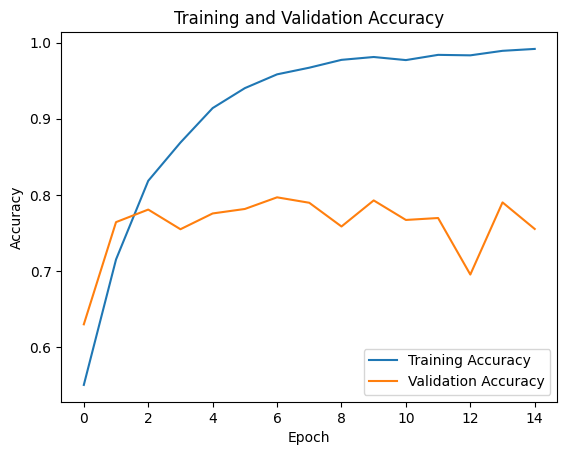

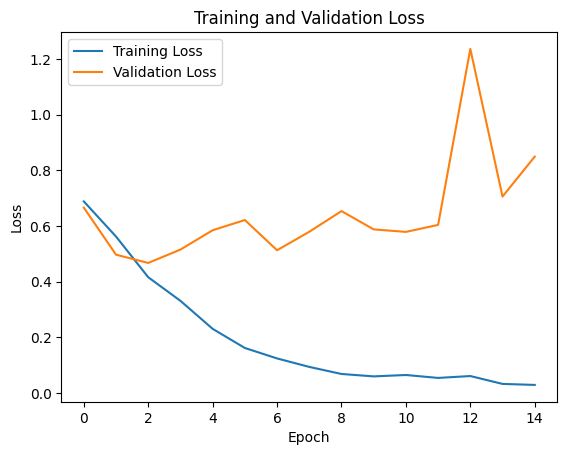

In [8]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Using the Embedded level to acquire embedded words

Putting an Anchoring level into Action


In [9]:
em_layer = layers.Embedding(input_dim=max_t, output_dim=256)

Anchor layer system which was developed form start

In [10]:
in1 = keras.Input(shape=(None,), dtype="int64")
em1 = layers.Embedding(input_dim=max_t, output_dim=256)(in1)
x = layers.Bidirectional(layers.LSTM(32))(em1)
x = layers.Dropout(0.5)(x)
ou1 = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(in1, ou1)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_2 (Embedding)              │ (None, None, 256)           │       2,560,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 64)                  │          73,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,634,049 (10.05 MB)

 Trainable params: 2,634,049 (10.05 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
cb1 = [
    keras.callbacks.ModelCheckpoint("embeddings_bidir_gru.keras",
                                    save_best_only=True)
]
hist1= model.fit(int_tr_ds, validation_data=int_v_ds, epochs=15, callbacks=cb1)
model = keras.models.load_model("embeddings_bidir_gru.keras")
print(f"Test acc: {model.evaluate(int_te_ds)[1]:.3f}")

Epoch 1/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - accuracy: 0.7975 - loss: 0.4303 - val_accuracy: 0.7919 - val_loss: 0.4483
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - accuracy: 0.8157 - loss: 0.4122 - val_accuracy: 0.7885 - val_loss: 0.4500
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 99ms/step - accuracy: 0.8111 - loss: 0.4126 - val_accuracy: 0.8003 - val_loss: 0.4347
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.8171 - loss: 0.4009 - val_accuracy: 0.7936 - val_loss: 0.4438
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.8272 - loss: 0.3822 - val_accuracy: 0.7889 - val_loss: 0.4512
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - accuracy: 0.8384 - loss: 0.3572 - val_accuracy: 0.8007 - val_loss: 0.4351
Epoch 7/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.8362 - loss: 0.3546 - val_accuracy: 0.8011 - val_loss: 0.4399
Epoch 8/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 119ms/step - accuracy: 0.8637 - loss: 0.3305 - v

In [34]:
test_loss, test_acc = model.evaluate(int_te_ds)
print(f"Test Loss: {test_loss:.3f}")
print(f"Test Accuracy: {test_acc:.3f}")

# Evaluate model on the validation dataset
val_loss, val_acc = model.evaluate(int_v_ds)
print(f"Validation Loss: {val_loss:.3f}")
print(f"Validation Accuracy: {val_acc:.3f}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.7981 - loss: 0.4368
Test Loss: 0.436
Test Accuracy: 0.798
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.7919 - loss: 0.4419
Validation Loss: 0.435
Validation Accuracy: 0.800


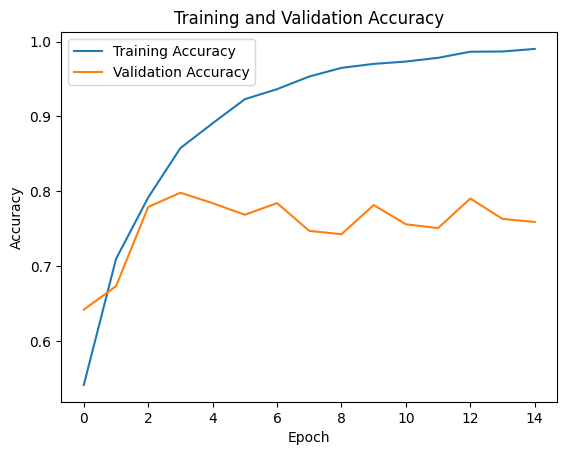

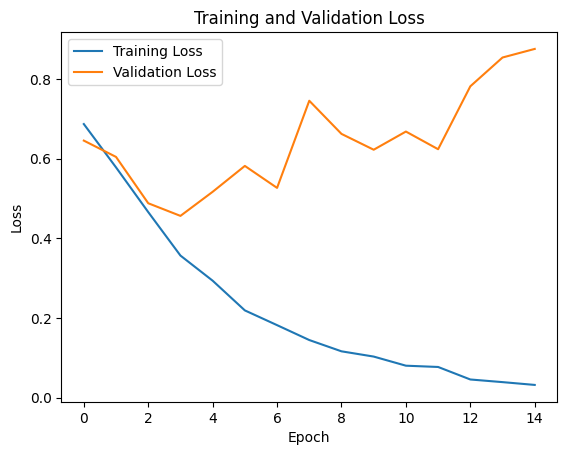

In [13]:
# Plot training and validation accuracy
plt.plot(hist1.history['accuracy'], label='Training Accuracy')
plt.plot(hist1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(hist1.history['loss'], label='Training Loss')
plt.plot(hist1.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Recognizing blurring and filling

Applying filtering to an Anchoring level


In [14]:
in2 = keras.Input(shape=(None,), dtype="int64")
em2 = layers.Embedding(
    input_dim=max_t, output_dim=256, mask_zero=True)(in2)
x = layers.Bidirectional(layers.LSTM(32))(em2)
x = layers.Dropout(0.5)(x)
ou2 = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(in2, ou2)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_3 (Embedding)   │ (None, None, 256)      │      2,560,000 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_2 (NotEqual)    │ (None, None)           │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_2           │ (None, 64)             │         73,984 │ embedding_3[0][0],     │
│ (Bidirectional)           │                        │                │ not_equal_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 64)             │              0 │ bidirectional_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 1)              │             65 │ dropout_2[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,634,049 (10.05 MB)

 Trainable params: 2,634,049 (10.05 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
cb2 = [
    keras.callbacks.ModelCheckpoint("embeddings_bidir_gru_with_masking.keras",
                                    save_best_only=True)
]
hist2=model.fit(int_tr_ds, validation_data=int_v_ds, epochs=15, callbacks=cb2)
model = keras.models.load_model("embeddings_bidir_gru_with_masking.keras")
print(f"Test acc: {model.evaluate(int_te_ds)[1]:.3f}")

Epoch 1/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - accuracy: 0.8251 - loss: 0.3992 - val_accuracy: 0.7988 - val_loss: 0.4507
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - accuracy: 0.8288 - loss: 0.3843 - val_accuracy: 0.7796 - val_loss: 0.4740
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.8290 - loss: 0.3678 - val_accuracy: 0.7816 - val_loss: 0.4916
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.8478 - loss: 0.3551 - val_accuracy: 0.7602 - val_loss: 0.5332
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 135ms/step - accuracy: 0.8561 - loss: 0.3365 - val_accuracy: 0.7984 - val_loss: 0.4375
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - accuracy: 0.8677 - loss: 0.3215 - val_accuracy: 0.8013 - val_loss: 0.4601
Epoch 7/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.8728 - loss: 0.3018 - val_accuracy: 0.7983 - val_loss: 0.4570
Epoch 8/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - accuracy: 0.8696 - loss: 0.3110 - va

In [36]:
test_loss, test_acc = model.evaluate(int_te_ds)
print(f"Test Loss: {test_loss:.3f}")
print(f"Test Accuracy: {test_acc:.3f}")

# Evaluate model on the validation dataset
val_loss, val_acc = model.evaluate(int_v_ds)
print(f"Validation Loss: {val_loss:.3f}")
print(f"Validation Accuracy: {val_acc:.3f}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.7977 - loss: 0.4374
Test Loss: 0.436
Test Accuracy: 0.798
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.7939 - loss: 0.4431
Validation Loss: 0.437
Validation Accuracy: 0.798


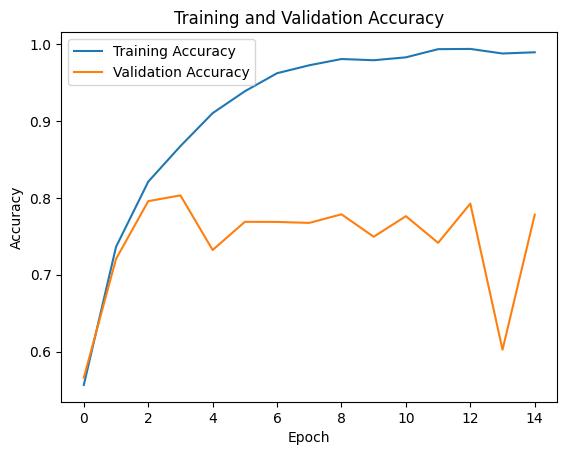

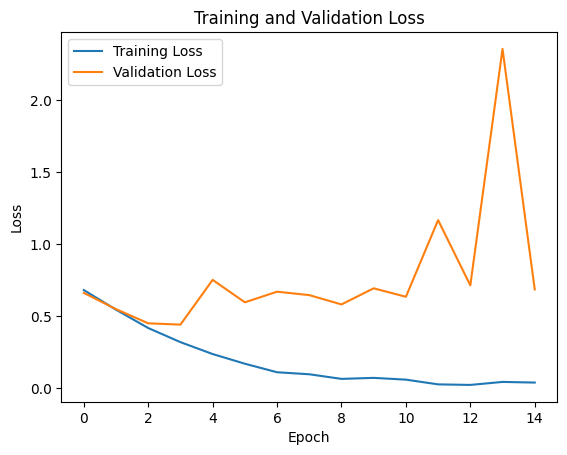

In [17]:
# Plot training and validation accuracy
plt.plot(hist2.history['accuracy'], label='Training Accuracy')
plt.plot(hist2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(hist2.history['loss'], label='Training Loss')
plt.plot(hist2.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Preconditioned word embeds are used

In [18]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2025-04-08 15:14:08--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-04-08 15:14:08--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-04-08 15:14:09--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

Interpreting the word-embeddings package for One

In [19]:
import numpy as np
path_to_g_file = "glove.6B.100d.txt"

em_index = {}
with open(path_to_g_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        em_index[word] = coefs

print(f"Found {len(em_index)} word vectors.")

Found 400000 word vectors.


Setting up the matrix for the GloVe website embedded words

In [20]:
em_dim = 100

vocab = t_vectorization.get_vocabulary()
wo_index = dict(zip(vocab, range(len(vocab))))

em_matrix = np.zeros((max_t, em_dim))
for word, i in wo_index.items():
    if i < max_t:
        em_vector = em_index.get(word)
    if em_vector is not None:
        em_matrix[i] = em_vector

In [21]:
em_layer = layers.Embedding(
    max_t,
    em_dim,
    embeddings_initializer=keras.initializers.Constant(em_matrix),
    trainable=False,
    mask_zero=True,
)

# Architecture with an embedded level which has been trained

In [22]:
in4 = keras.Input(shape=(None,), dtype="int64")
em4 = em_layer(in4)
x = layers.Bidirectional(layers.LSTM(32))(em4)
x = layers.Dropout(0.5)(x)
ou4 = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(in4, ou4)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_4 (Embedding)   │ (None, None, 100)      │      1,000,000 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_4 (NotEqual)    │ (None, None)           │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_3           │ (None, 64)             │         34,048 │ embedding_4[0][0],     │
│ (Bidirectional)           │                        │                │ not_equal_4[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 64)             │              0 │ bidirectional_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 1)              │             65 │ dropout_3[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,034,113 (3.94 MB)

 Trainable params: 34,113 (133.25 KB)

 Non-trainable params: 1,000,000 (3.81 MB)

In [37]:
cb4 = [
    keras.callbacks.ModelCheckpoint("glove_embeddings_sequence_model.keras",
                                    save_best_only=True)
]
hist4=model.fit(int_tr_ds, validation_data=int_v_ds, epochs=15, callbacks=cb4)
model = keras.models.load_model("glove_embeddings_sequence_model.keras")
print(f"Test acc: {model.evaluate(int_te_ds)[1]:.3f}")

Epoch 1/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - accuracy: 0.8653 - loss: 0.3175 - val_accuracy: 0.7764 - val_loss: 0.4749
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.8716 - loss: 0.3077 - val_accuracy: 0.7659 - val_loss: 0.5071
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - accuracy: 0.8782 - loss: 0.2888 - val_accuracy: 0.7960 - val_loss: 0.4776
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 79ms/step - accuracy: 0.8858 - loss: 0.2708 - val_accuracy: 0.7969 - val_loss: 0.4552
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - accuracy: 0.8957 - loss: 0.2601 - val_accuracy: 0.7836 - val_loss: 0.5088
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.8982 - loss: 0.2496 - val_accuracy: 0.7961 - val_loss: 0.4694
Epoch 7/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - accuracy: 0.9015 - loss: 0.2380 - val_accuracy: 0.7807 - val_loss: 0.5565
Epoch 8/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 126ms/step - accuracy: 0.9114 - loss: 0.2231 - v

In [38]:
test_loss, test_acc = model.evaluate(int_te_ds)
print(f"Test Loss: {test_loss:.3f}")
print(f"Test Accuracy: {test_acc:.3f}")

# Evaluate model on the validation dataset
val_loss, val_acc = model.evaluate(int_v_ds)
print(f"Validation Loss: {val_loss:.3f}")
print(f"Validation Accuracy: {val_acc:.3f}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.7986 - loss: 0.4536
Test Loss: 0.453
Test Accuracy: 0.798
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.7901 - loss: 0.4610
Validation Loss: 0.455
Validation Accuracy: 0.797


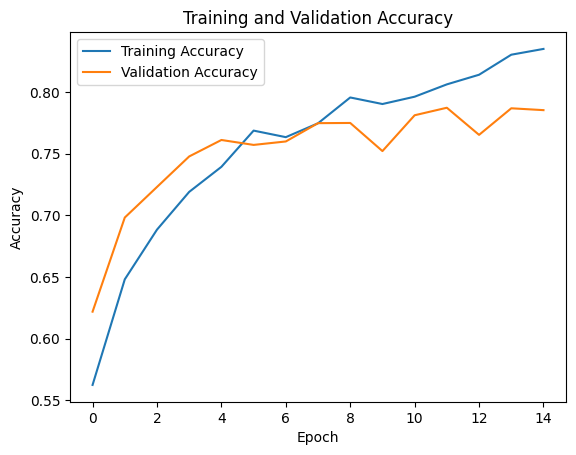

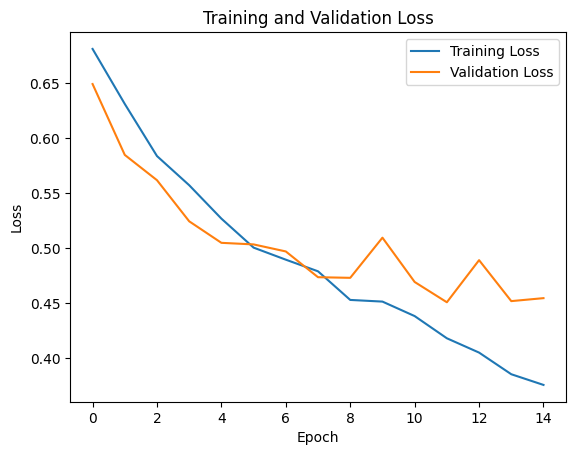

In [24]:
# Plot training and validation accuracy
plt.plot(hist4.history['accuracy'], label='Training Accuracy')
plt.plot(hist4.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(hist4.history['loss'], label='Training Loss')
plt.plot(hist4.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Found 5000 files belonging to 2 classes.
Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step - accuracy: 0.5009 - loss: 0.6939 - val_accuracy: 0.5407 - val_loss: 0.6899
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.6132 - loss: 0.6697 - val_accuracy: 0.6945 - val_loss: 0.5931
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - accuracy: 0.7443 - loss: 0.5497 - val_accuracy: 0.7438 - val_loss: 0.5311
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - accuracy: 0.8113 - loss: 0.4563 - val_accuracy: 0.6370 - val_loss: 0.7164
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.8637 - loss: 0.3605 - val_accuracy: 0.7823 - val_loss: 0.4656
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - accuracy: 0.9129 - loss: 0.2701 - val_accuracy: 0.7891 - val_loss: 0.4648
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.9287 - loss: 0.2255 - val_accuracy: 0.7395 - val_loss: 0.6949
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step -

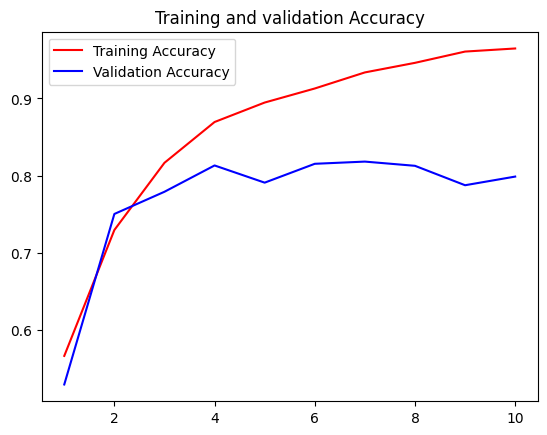

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 67ms/step - accuracy: 0.5491 - loss: 0.6885 - val_accuracy: 0.6742 - val_loss: 0.6107
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 81ms/step - accuracy: 0.6847 - loss: 0.6012 - val_accuracy: 0.5943 - val_loss: 0.6681
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 17s 56ms/step - accuracy: 0.7001 - loss: 0.5640 - val_accuracy: 0.6736 - val_loss: 0.6107
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - accuracy: 0.7318 - loss: 0.5310 - val_accuracy: 0.7172 - val_loss: 0.5479
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - accuracy: 0.7670 - loss: 0.4949 - val_accuracy: 0.7394 - val_loss: 0.5404
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.7833 - loss: 0.4703 - val_accuracy: 0.6913 - val_loss: 0.5815
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - accuracy: 0.7903 - loss: 0.4552 - val_accuracy: 0.7929 - val_loss: 0.4432
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 23s 81ms/step - accuracy: 0.8085 - loss: 0.4328 - v

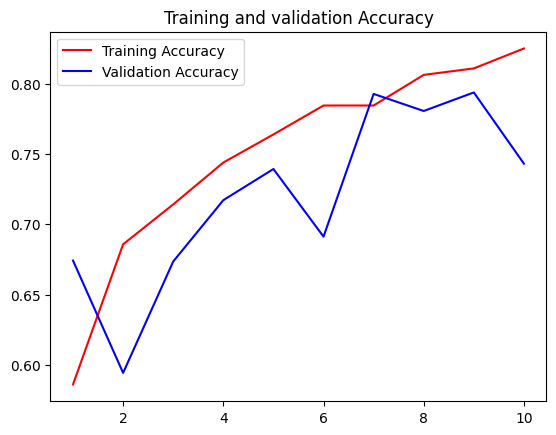

Training samples: 20000
Embedding layer test accuracy: 0.805
Pretrained embeddings test accuracy: 0.787
--------------------------------------------------


In [44]:
train_sample_sizes = [100, 1000, 3000, 5000, 10000, 20000]
for train_size in train_sample_sizes:
    train_ds = keras.utils.text_dataset_from_directory(
        "aclImdb/train", batch_size=b_size
    ).take(train_size)

    int_train_ds = train_ds.map(
        lambda x, y: (t_vectorization(x), y),
        num_parallel_calls=4
    )
    int_val_ds = v_ds.map(
        lambda x, y: (t_vectorization(x), y),
        num_parallel_calls=4
    )
    int_test_ds = te_ds.map(
        lambda x, y: (t_vectorization(x), y),
        num_parallel_calls=4
    )

    # Train and evaluate the model with the embedding layer
    embedding_layer = layers.Embedding(max_t, em_dim)

    inputs = keras.Input(shape=(None,), dtype="int64")
    embedded = embedding_layer(inputs)
    x = layers.Bidirectional(layers.LSTM(32))(embedded)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop",
                  loss="binary_crossentropy",
                  metrics=["accuracy"])

    callbacks = [
        keras.callbacks.ModelCheckpoint("embeddings_model.keras",
                                        save_best_only=True)
    ]
    history = model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
    model = keras.models.load_model("embeddings_model.keras")


test_loss, test_acc = model.evaluate(int_te_ds)
print(f"Test Loss: {test_loss:.3f}")
print(f"Test Accuracy: {test_acc:.3f}")

# Evaluate model on the validation dataset
val_loss, val_acc = model.evaluate(int_v_ds)
print(f"Validation Loss: {val_loss:.3f}")
print(f"Validation Accuracy: {val_acc:.3f}")


embedding_layer_test_acc = model.evaluate(int_test_ds)[1]

loss = history.history["accuracy"]
val_loss = history.history["val_accuracy"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "r", label="Training Accuracy")
plt.plot(epochs, val_loss, "b", label="Validation Accuracy")
plt.title("Training and validation Accuracy")
plt.legend()
plt.show()

# Train and evaluate the model with the pretrained word embeddings
embedding_layer = layers.Embedding(
        max_t,
        em_dim,
        embeddings_initializer=keras.initializers.Constant(em_matrix),
        trainable=False,
        mask_zero=True,
    )

inputs = keras.Input(shape=(None,), dtype="int64")
embedded = embedding_layer(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
                  loss="binary_crossentropy",
                  metrics=["accuracy"])

callbacks = [
        keras.callbacks.ModelCheckpoint("pretrained_embeddings_model.keras",
                                        save_best_only=True)
    ]
history = model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model = keras.models.load_model("pretrained_embeddings_model.keras")
pretrained_embeddings_test_acc = model.evaluate(int_test_ds)[1]

loss = history.history["accuracy"]
val_loss = history.history["val_accuracy"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "r", label="Training Accuracy")
plt.plot(epochs, val_loss, "b", label="Validation Accuracy")
plt.title("Training and validation Accuracy")
plt.legend()
plt.show()

# Compare the performance and store the results
print(f"Training samples: {train_size}")
print(f"Embedding layer test accuracy: {embedding_layer_test_acc:.3f}")
print(f"Pretrained embeddings test accuracy: {pretrained_embeddings_test_acc:.3f}")
print("-" * 50)


Training with 100 samples...
Found 5000 files belonging to 2 classes.
Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - accuracy: 0.5261 - loss: 0.6925 - val_accuracy: 0.5304 - val_loss: 0.6891
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - accuracy: 0.6247 - loss: 0.6580 - val_accuracy: 0.7315 - val_loss: 0.5711
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.7751 - loss: 0.5168 - val_accuracy: 0.7599 - val_loss: 0.5138
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - accuracy: 0.8468 - loss: 0.3926 - val_accuracy: 0.7578 - val_loss: 0.5130
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.8928 - loss: 0.3095 - val_accuracy: 0.7396 - val_loss: 0.6556
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - accuracy: 0.9210 - loss: 0.2438 - val_accuracy: 0.7103 - val_loss: 0.6314
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - accuracy: 0.9219 - loss: 0.2265 - val_accuracy: 0.7006 - val_loss: 0.7140
Epoch 8/10
100/100 ━━━━━

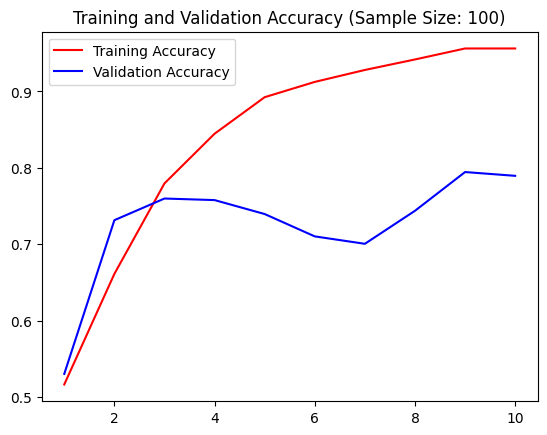

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - accuracy: 0.5335 - loss: 0.6922 - val_accuracy: 0.6176 - val_loss: 0.6502
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 18s 79ms/step - accuracy: 0.6578 - loss: 0.6216 - val_accuracy: 0.6656 - val_loss: 0.6066
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 88ms/step - accuracy: 0.6963 - loss: 0.5824 - val_accuracy: 0.6957 - val_loss: 0.5805
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 97ms/step - accuracy: 0.7345 - loss: 0.5370 - val_accuracy: 0.7433 - val_loss: 0.5361
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - accuracy: 0.7436 - loss: 0.5207 - val_accuracy: 0.7323 - val_loss: 0.5345
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - accuracy: 0.7658 - loss: 0.4986 - val_accuracy: 0.7621 - val_loss: 0.4989
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 94ms/step - accuracy: 0.7687 - loss: 0.4941 - val_accuracy: 0.7670 - val_loss: 0.4923
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 136ms/step - accuracy: 0.7893 - loss: 0.4636 - 

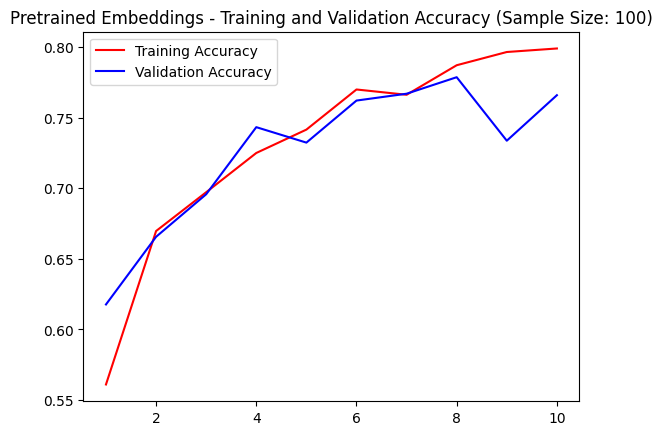

Training samples: 100
Embedding layer test accuracy: 0.751
Pretrained embeddings test accuracy: 0.772
--------------------------------------------------
Training with 1000 samples...
Found 5000 files belonging to 2 classes.
Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.5370 - loss: 0.6884 - val_accuracy: 0.6208 - val_loss: 0.6687
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.7218 - loss: 0.5625 - val_accuracy: 0.6079 - val_loss: 0.7415
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 82ms/step - accuracy: 0.8108 - loss: 0.4347 - val_accuracy: 0.8008 - val_loss: 0.5011
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 16s 53ms/step - accuracy: 0.8705 - loss: 0.3440 - val_accuracy: 0.8159 - val_loss: 0.4211
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.8965 - loss: 0.2825 - val_accuracy: 0.7904 - val_loss: 0.4561
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.9233 - loss: 0.2232 - val_accuracy: 0.8052 - val_loss: 0.490

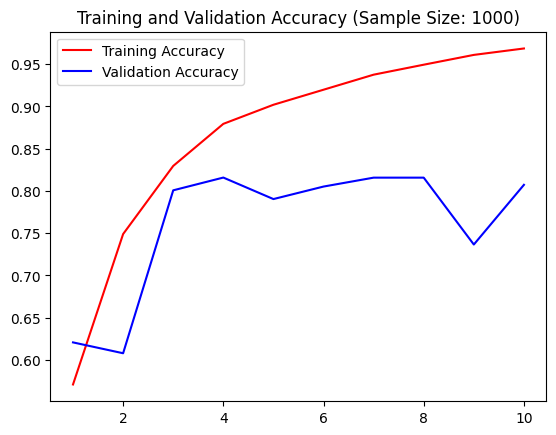

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.5406 - loss: 0.6951 - val_accuracy: 0.6735 - val_loss: 0.6150
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 64ms/step - accuracy: 0.6564 - loss: 0.6218 - val_accuracy: 0.6842 - val_loss: 0.5879
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.7074 - loss: 0.5722 - val_accuracy: 0.7593 - val_loss: 0.5064
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - accuracy: 0.7434 - loss: 0.5195 - val_accuracy: 0.7660 - val_loss: 0.4887
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 94ms/step - accuracy: 0.7650 - loss: 0.5013 - val_accuracy: 0.7734 - val_loss: 0.4712
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - accuracy: 0.7718 - loss: 0.4828 - val_accuracy: 0.7776 - val_loss: 0.4704
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.7923 - loss: 0.4628 - val_accuracy: 0.7853 - val_loss: 0.4531
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.7974 - loss: 0.4359 - 

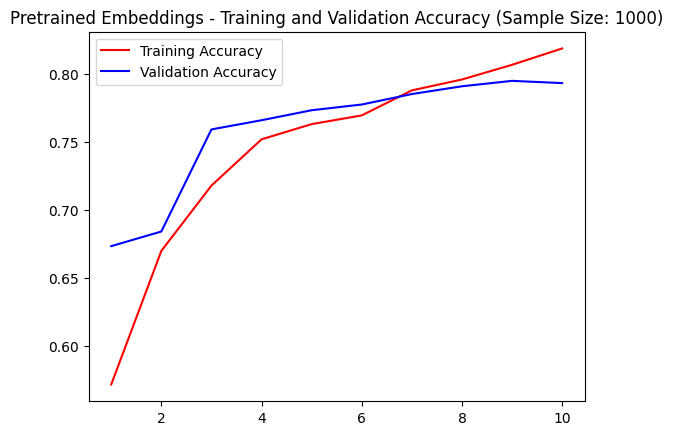

Training samples: 1000
Embedding layer test accuracy: 0.810
Pretrained embeddings test accuracy: 0.789
--------------------------------------------------
Training with 3000 samples...
Found 5000 files belonging to 2 classes.
Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - accuracy: 0.5306 - loss: 0.6889 - val_accuracy: 0.7114 - val_loss: 0.5863
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - accuracy: 0.7072 - loss: 0.5865 - val_accuracy: 0.7284 - val_loss: 0.5579
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 81ms/step - accuracy: 0.8015 - loss: 0.4609 - val_accuracy: 0.8001 - val_loss: 0.4684
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 81ms/step - accuracy: 0.8546 - loss: 0.3663 - val_accuracy: 0.5672 - val_loss: 1.1310
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.8780 - loss: 0.3248 - val_accuracy: 0.7972 - val_loss: 0.4862
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - accuracy: 0.9110 - loss: 0.2349 - val_accuracy: 0.8098 - val_loss: 0.47

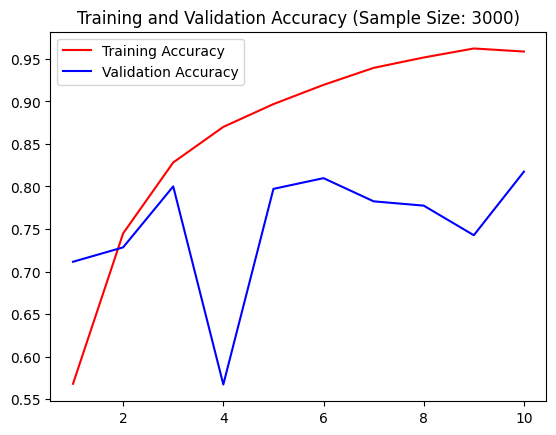

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - accuracy: 0.5457 - loss: 0.6929 - val_accuracy: 0.5886 - val_loss: 0.6875
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - accuracy: 0.6683 - loss: 0.6118 - val_accuracy: 0.6963 - val_loss: 0.5857
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 25s 92ms/step - accuracy: 0.7081 - loss: 0.5745 - val_accuracy: 0.7533 - val_loss: 0.5172
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 94ms/step - accuracy: 0.7294 - loss: 0.5423 - val_accuracy: 0.7477 - val_loss: 0.5124
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.7562 - loss: 0.5144 - val_accuracy: 0.7715 - val_loss: 0.4787
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - accuracy: 0.7719 - loss: 0.4903 - val_accuracy: 0.7897 - val_loss: 0.4673
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 18s 48ms/step - accuracy: 0.7797 - loss: 0.4769 - val_accuracy: 0.7531 - val_loss: 0.5011
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.7908 - loss: 0.4503 - v

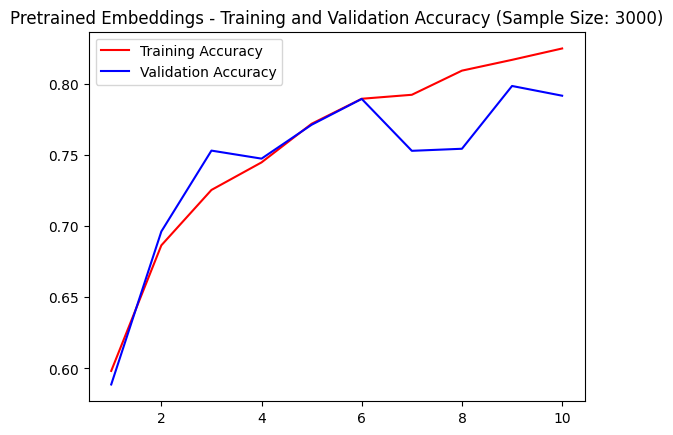

Training samples: 3000
Embedding layer test accuracy: 0.798
Pretrained embeddings test accuracy: 0.791
--------------------------------------------------
Training with 5000 samples...
Found 5000 files belonging to 2 classes.
Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - accuracy: 0.5228 - loss: 0.6901 - val_accuracy: 0.5907 - val_loss: 0.6815
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 81ms/step - accuracy: 0.7004 - loss: 0.5868 - val_accuracy: 0.7111 - val_loss: 0.5773
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 16s 52ms/step - accuracy: 0.8235 - loss: 0.4364 - val_accuracy: 0.8042 - val_loss: 0.4369
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 16s 86ms/step - accuracy: 0.8498 - loss: 0.3603 - val_accuracy: 0.8060 - val_loss: 0.4377
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - accuracy: 0.9012 - loss: 0.2746 - val_accuracy: 0.8187 - val_loss: 0.4423
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.9188 - loss: 0.2271 - val_accuracy: 0.8104 - val_loss: 0.47

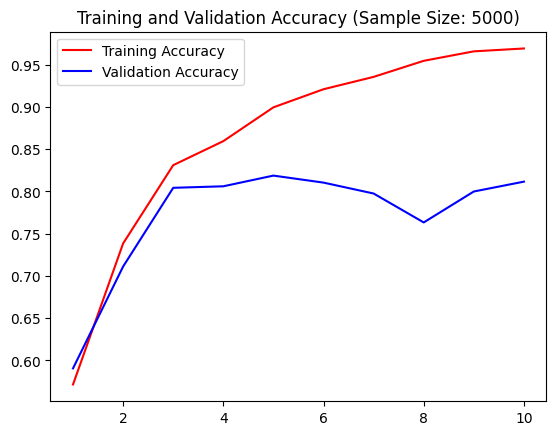

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 16s 93ms/step - accuracy: 0.5442 - loss: 0.6899 - val_accuracy: 0.6561 - val_loss: 0.6286
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.6788 - loss: 0.6082 - val_accuracy: 0.7133 - val_loss: 0.5807
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 73ms/step - accuracy: 0.7182 - loss: 0.5630 - val_accuracy: 0.7450 - val_loss: 0.5375
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 67ms/step - accuracy: 0.7398 - loss: 0.5285 - val_accuracy: 0.7714 - val_loss: 0.4815
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.7612 - loss: 0.4954 - val_accuracy: 0.5979 - val_loss: 0.7199
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - accuracy: 0.7710 - loss: 0.4850 - val_accuracy: 0.7719 - val_loss: 0.4923
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - accuracy: 0.7885 - loss: 0.4552 - val_accuracy: 0.7797 - val_loss: 0.4749
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 21s 66ms/step - accuracy: 0.7989 - loss: 0.4465 - v

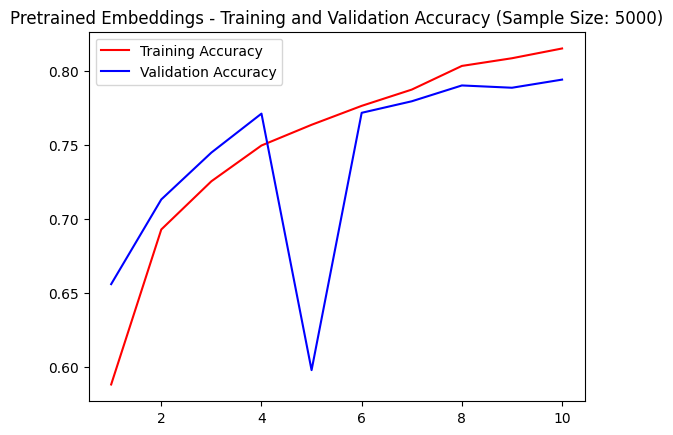

Training samples: 5000
Embedding layer test accuracy: 0.796
Pretrained embeddings test accuracy: 0.792
--------------------------------------------------
Training with 10000 samples...
Found 5000 files belonging to 2 classes.
Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - accuracy: 0.5321 - loss: 0.6917 - val_accuracy: 0.5235 - val_loss: 0.6984
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 14s 82ms/step - accuracy: 0.6730 - loss: 0.6118 - val_accuracy: 0.7637 - val_loss: 0.5167
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.8110 - loss: 0.4444 - val_accuracy: 0.7787 - val_loss: 0.4772
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - accuracy: 0.8518 - loss: 0.3683 - val_accuracy: 0.8003 - val_loss: 0.4471
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.8838 - loss: 0.3080 - val_accuracy: 0.7990 - val_loss: 0.5913
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - accuracy: 0.9153 - loss: 0.2506 - val_accuracy: 0.7531 - val_loss: 0.55

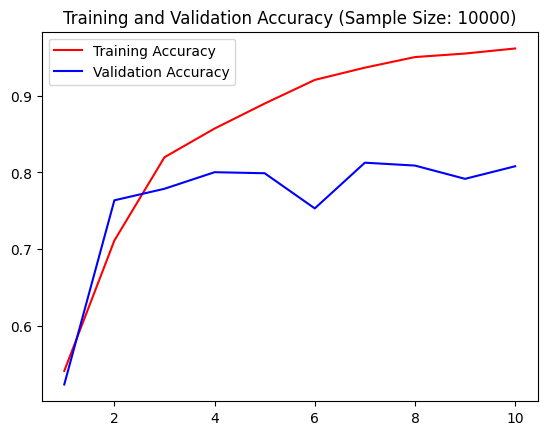

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 69ms/step - accuracy: 0.5523 - loss: 0.6869 - val_accuracy: 0.6849 - val_loss: 0.6033
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - accuracy: 0.6762 - loss: 0.6055 - val_accuracy: 0.6043 - val_loss: 0.7497
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.7197 - loss: 0.5550 - val_accuracy: 0.6231 - val_loss: 0.6528
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 59ms/step - accuracy: 0.7356 - loss: 0.5289 - val_accuracy: 0.7661 - val_loss: 0.4932
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 83ms/step - accuracy: 0.7683 - loss: 0.4916 - val_accuracy: 0.7375 - val_loss: 0.5228
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 17s 60ms/step - accuracy: 0.7730 - loss: 0.4716 - val_accuracy: 0.7694 - val_loss: 0.4813
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - accuracy: 0.7867 - loss: 0.4566 - val_accuracy: 0.7630 - val_loss: 0.4941
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 107ms/step - accuracy: 0.7884 - loss: 0.4468 - va

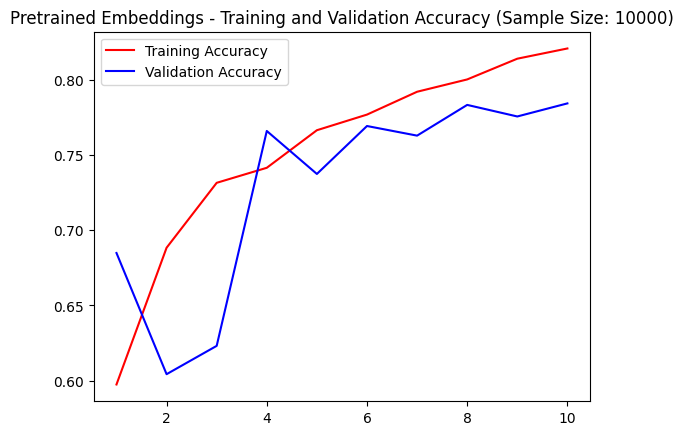

Training samples: 10000
Embedding layer test accuracy: 0.794
Pretrained embeddings test accuracy: 0.783
--------------------------------------------------
Training with 20000 samples...
Found 5000 files belonging to 2 classes.
Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 84ms/step - accuracy: 0.5363 - loss: 0.6888 - val_accuracy: 0.6688 - val_loss: 0.6372
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - accuracy: 0.7189 - loss: 0.5704 - val_accuracy: 0.7136 - val_loss: 0.5557
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - accuracy: 0.8068 - loss: 0.4433 - val_accuracy: 0.6309 - val_loss: 0.9298
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - accuracy: 0.8568 - loss: 0.3721 - val_accuracy: 0.7895 - val_loss: 0.5230
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.8919 - loss: 0.2962 - val_accuracy: 0.7954 - val_loss: 0.4698
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - accuracy: 0.9023 - loss: 0.2603 - val_accuracy: 0.8164 - val_loss: 0.4

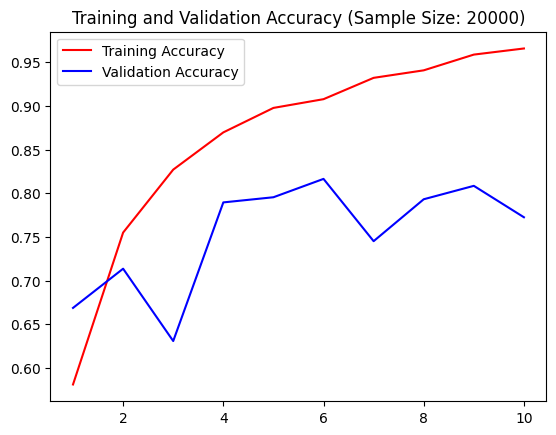

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 67ms/step - accuracy: 0.5518 - loss: 0.6875 - val_accuracy: 0.6587 - val_loss: 0.6235
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 57ms/step - accuracy: 0.6684 - loss: 0.6122 - val_accuracy: 0.5769 - val_loss: 0.6823
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 66ms/step - accuracy: 0.7054 - loss: 0.5677 - val_accuracy: 0.7454 - val_loss: 0.5242
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.7337 - loss: 0.5416 - val_accuracy: 0.6890 - val_loss: 0.6634
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 61ms/step - accuracy: 0.7689 - loss: 0.4976 - val_accuracy: 0.7760 - val_loss: 0.4728
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.7683 - loss: 0.4941 - val_accuracy: 0.7493 - val_loss: 0.5087
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.7838 - loss: 0.4676 - val_accuracy: 0.6996 - val_loss: 0.5710
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 14s 81ms/step - accuracy: 0.7905 - loss: 0.4593 - va

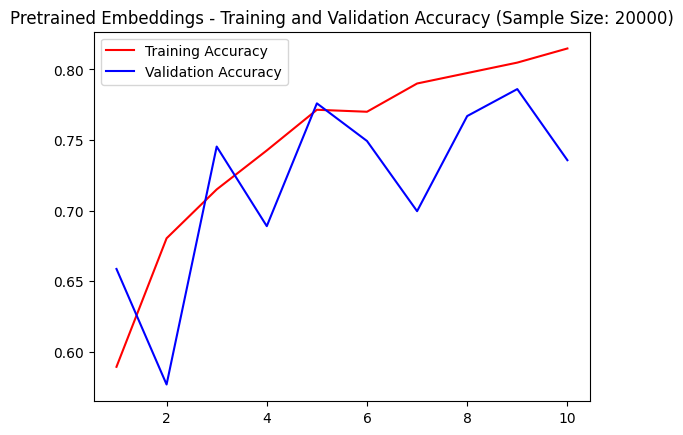

Training samples: 20000
Embedding layer test accuracy: 0.806
Pretrained embeddings test accuracy: 0.784
--------------------------------------------------
Training samples: 100
Embedding layer test accuracy: 0.751


ValueError: Unknown format code 'f' for object of type 'str'

In [45]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Initialize the results list to store metrics
results = []

train_sample_sizes = [100, 1000, 3000, 5000, 10000, 20000]
for train_size in train_sample_sizes:
    print(f"Training with {train_size} samples...")

    # Load training dataset with the specific sample size
    train_ds = keras.utils.text_dataset_from_directory(
        "aclImdb/train", batch_size=b_size
    ).take(train_size)

    # Map datasets for vectorization
    int_train_ds = train_ds.map(
        lambda x, y: (t_vectorization(x), y),
        num_parallel_calls=4
    )
    int_val_ds = v_ds.map(
        lambda x, y: (t_vectorization(x), y),
        num_parallel_calls=4
    )
    int_test_ds = te_ds.map(
        lambda x, y: (t_vectorization(x), y),
        num_parallel_calls=4
    )

    # Train and evaluate the model with the embedding layer
    embedding_layer = layers.Embedding(max_t, em_dim)

    inputs = keras.Input(shape=(None,), dtype="int64")
    embedded = embedding_layer(inputs)
    x = layers.Bidirectional(layers.LSTM(32))(embedded)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop",
                  loss="binary_crossentropy",
                  metrics=["accuracy"])

    callbacks = [
        keras.callbacks.ModelCheckpoint("embeddings_model.keras", save_best_only=True)
    ]
    history = model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
    model = keras.models.load_model("embeddings_model.keras")

    # Evaluate on the test set
    test_loss, test_acc = model.evaluate(int_test_ds)
    print(f"Test Loss: {test_loss:.3f}")
    print(f"Test Accuracy: {test_acc:.3f}")

    # Evaluate on the validation set
    val_loss, val_acc = model.evaluate(int_val_ds)
    print(f"Validation Loss: {val_loss:.3f}")
    print(f"Validation Accuracy: {val_acc:.3f}")

    # Store results for embedding layer
    embedding_layer_test_acc = test_acc
    embedding_layer_val_acc = val_acc
    embedding_layer_train_acc = history.history['accuracy'][-1]
    embedding_layer_val_loss = history.history['val_loss'][-1]

    # Store results
    results.append({
        'train_size': train_size,
        'embedding_layer_test_acc': embedding_layer_test_acc,
        'embedding_layer_val_acc': embedding_layer_val_acc,
        'embedding_layer_train_acc': embedding_layer_train_acc,
        'embedding_layer_val_loss': embedding_layer_val_loss
    })

    # Plot the training and validation accuracy
    loss = history.history["accuracy"]
    val_loss = history.history["val_accuracy"]
    epochs = range(1, len(loss) + 1)

    plt.figure()
    plt.plot(epochs, loss, "r", label="Training Accuracy")
    plt.plot(epochs, val_loss, "b", label="Validation Accuracy")
    plt.title(f"Training and Validation Accuracy (Sample Size: {train_size})")
    plt.legend()
    plt.show()

    # Now train and evaluate with the pretrained word embeddings
    embedding_layer = layers.Embedding(
        max_t,
        em_dim,
        embeddings_initializer=keras.initializers.Constant(em_matrix),
        trainable=False,
        mask_zero=True,
    )

    inputs = keras.Input(shape=(None,), dtype="int64")
    embedded = embedding_layer(inputs)
    x = layers.Bidirectional(layers.LSTM(32))(embedded)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop",
                  loss="binary_crossentropy",
                  metrics=["accuracy"])

    callbacks = [
        keras.callbacks.ModelCheckpoint("pretrained_embeddings_model.keras", save_best_only=True)
    ]
    history = model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
    model = keras.models.load_model("pretrained_embeddings_model.keras")

    # Evaluate on the test set
    pretrained_embeddings_test_acc = model.evaluate(int_test_ds)[1]

    # Plot the training and validation accuracy for pretrained embeddings
    loss = history.history["accuracy"]
    val_loss = history.history["val_accuracy"]
    epochs = range(1, len(loss) + 1)

    plt.figure()
    plt.plot(epochs, loss, "r", label="Training Accuracy")
    plt.plot(epochs, val_loss, "b", label="Validation Accuracy")
    plt.title(f"Pretrained Embeddings - Training and Validation Accuracy (Sample Size: {train_size})")
    plt.legend()
    plt.show()

    # Store results for pretrained embeddings
    results.append({
        'train_size': train_size,
        'pretrained_embeddings_test_acc': pretrained_embeddings_test_acc
    })

    print(f"Training samples: {train_size}")
    print(f"Embedding layer test accuracy: {embedding_layer_test_acc:.3f}")
    print(f"Pretrained embeddings test accuracy: {pretrained_embeddings_test_acc:.3f}")
    print("-" * 50)

# After all iterations, print the summary of results
for result in results:
    print(f"Training samples: {result['train_size']}")
    print(f"Embedding layer test accuracy: {result.get('embedding_layer_test_acc', 'N/A'):.3f}")
    print(f"Pretrained embeddings test accuracy: {result.get('pretrained_embeddings_test_acc', 'N/A'):.3f}")
    print("-" * 50)
